In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from notebooks.districts_hoods import *

In [2]:
df = pd.read_csv("/home/maxim/pozorniki/_data.csv", index_col=0)

In [3]:
#Переименовываем столбцы на латинские названия для избежания потенциальных ошибок

df.columns = ['ID', 'rooms', 'apt_type', 'metro', 'address',
       'apartment_sqm', 'floors_and_type', 'parking', 'price', 'tel', 'description',
       'style', 'rooms_sqm', 'balcony', 'window_view', 'bathroom_count',
       'kids_pets', 'utilities', 'building_name',
       'building_series', 'ceiling_height', 'elevator', 'trash',
       'cian link']

In [4]:

#делаем копию датасета на всякий случай, добавляем новый столбец с городом, фильтрует по МСК и убираем остальные города, т.к. задание подразумевает анализ исключительно в МСК

df2 = df.copy()
df2["city"] = df2["address"].apply(lambda x: (str(x).split(","))[0])
df2 = df2[df2["city"] == "Москва"]
df2.drop(columns=["city"], inplace=True)




In [5]:
#Смотрим общую информацию по таблице и на типы данных в столбцах
df2.info()
df2.dtypes

<class 'pandas.core.frame.DataFrame'>
Index: 19737 entries, 0 to 23367
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               19737 non-null  int64  
 1   rooms            19202 non-null  object 
 2   apt_type         19737 non-null  object 
 3   metro            19391 non-null  object 
 4   address          19737 non-null  object 
 5   apartment_sqm    19737 non-null  object 
 6   floors_and_type  19737 non-null  object 
 7   parking          8563 non-null   object 
 8   price            19737 non-null  object 
 9   tel              19737 non-null  object 
 10  description      19737 non-null  object 
 11  style            17274 non-null  object 
 12  rooms_sqm        12509 non-null  object 
 13  balcony          13107 non-null  object 
 14  window_view      14587 non-null  object 
 15  bathroom_count   17696 non-null  object 
 16  kids_pets        14822 non-null  object 
 17  utilities        

ID                   int64
rooms               object
apt_type            object
metro               object
address             object
apartment_sqm       object
floors_and_type     object
parking             object
price               object
tel                 object
description         object
style               object
rooms_sqm           object
balcony             object
window_view         object
bathroom_count      object
kids_pets           object
utilities           object
building_name       object
building_series     object
ceiling_height     float64
elevator            object
trash               object
cian link           object
dtype: object

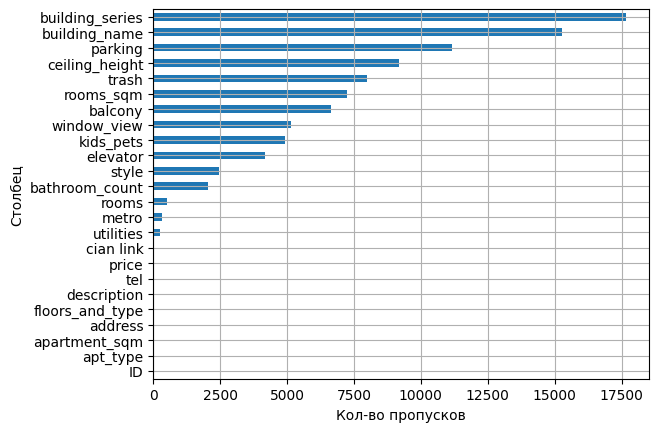

In [6]:
#проверяем на дубликаты данные

int(df2.duplicated().sum())

#Смотрим на заполненность столбцов и кол-во пустых ячеек в них
df2.isna().sum().sort_values().plot.barh()
plt.xlabel("Кол-во пропусков")
plt.ylabel("Столбец")
plt.grid()



In [7]:
#Анализируем столбцы с большим кол-ом пропусков на надобность в заполнении пустых ячеек
#Building Series & Building name - не нужны, никакой полезной информации они не несут
#Parking - потенциально важный показатель для анализа, пустые значения скорее всего означают отсутствие выделенной парковки и будут заполнены соответственным образом
#Ceiling height - возможно нужен. Пустые значения скорее всего просто не заполнялись при создании. 
#Возможно для анализа не будем использовать, в ином случае заполним как 2.5м (стандратной высотой квартир).
#Trash - потенциально не показательная характеристика, будет проверена далее более точно
#Rooms_sqm - показатель, который не стоит учитывать в анализе, т.к. слишком много пустых значений, которые могут быть абсолютно разные и применять средние будет нерелевантно
#Balcony - может сильно влиять на цену. Пропуски потенциально означают остуствие балкона, которые стоит заполнить нулями
#Window view - возможно нужный показатель, однако не понятно как заполнять как пропуски
#Kids_pets - не учитываем, т.к. единственный оставшийся вариант на циане: "не важно", что никак не дает понять наверняка можно ли с детьми или животными или нельзя.
#Elevator - не учитываем, т.к. даже в заполненных полях на одинаковых адресах присутствуют разные данные, что только ведут к некорректности
#Style - ремонт важен. оставляем
#Bathroom_count - важно, пустые заполним как 1



In [8]:
# Понимая, что по-хорошему на каждый дом показатели  наличия парковки, кол-ва лифтов и наличия мусоропровода должно быть одикаковым для всех размещений
# Выведем кол-во уникальных значений по этим парамметрам для каждого адреса, чтоб понять насколько данные отражают действительность и влияния чел.фактора при заполнении

dff = df2[["address","metro","parking","elevator","trash"]].groupby("address")[["metro","parking","elevator","trash"]].apply(lambda x: x.nunique())

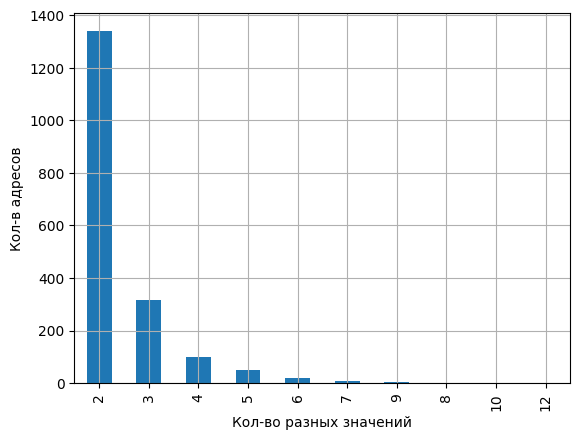

In [9]:
dff[dff["elevator"] > 1]["elevator"].value_counts().plot.bar()
plt.xlabel("Кол-во разных значений")
plt.ylabel("Кол-в адресов")
plt.grid()


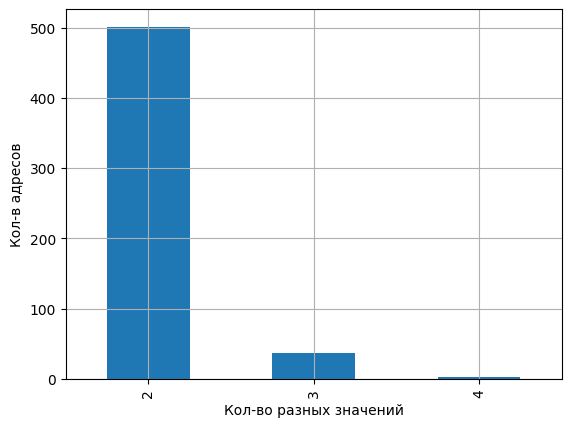

In [10]:
dff[dff["parking"] > 1]["parking"].value_counts().plot.bar()
plt.xlabel("Кол-во разных значений")
plt.ylabel("Кол-в адресов")
plt.grid()

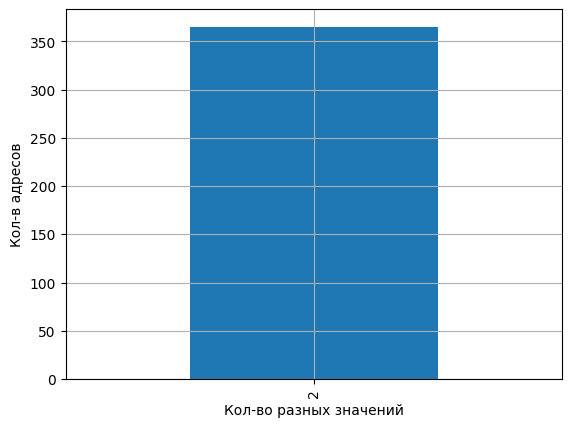

In [11]:
dff[dff["trash"] > 1]["trash"].value_counts().plot.bar()
plt.xlabel("Кол-во разных значений")
plt.ylabel("Кол-в адресов")
plt.grid()

In [12]:
# По данным показателям можем сделать вывод, что данные по стобцам мусоропровода и лифтам лучше не использовать при анализе
# А данные по парковкам стоит возможно преобразовать в булевые значения - Есть парковка/Нет парковки. Но возможно просто заполним пропуски как "нет парковки"

In [13]:
#Приводим цены к одному порядку, переводим валюту в рубли и для удобства выводим в новый столбец, для дальшего анализа и построения графиком с числовой величиной
import requests
from xml.etree import ElementTree

def get_exchange_rate(currency_code):
    # URL для получения курсов валют от ЦБ РФ
    url = "https://www.cbr.ru/scripts/XML_daily.asp"
    response = requests.get(url)
    response.encoding = 'windows-1251'  # Устанавливаем правильную кодировку для XML

    # Парсим XML
    tree = ElementTree.fromstring(response.text)

    # Ищем нужную валюту по коду (например, USD или EUR)
    for currency in tree.findall("Valute"):
        char_code = currency.find("CharCode").text
        if char_code == currency_code:
            value = currency.find("Value").text.replace(",", ".")
            return float(value)

# Получаем курсы валют
usd_to_rub = get_exchange_rate("USD")  # Курс доллара к рублю
eur_to_rub = get_exchange_rate("EUR")  # Курс евро к рублю

print(f"Текущий курс доллара по ЦБ: {usd_to_rub} руб.")
print(f"Текущий курс евро по ЦБ: {eur_to_rub} руб.")

def convert_price(n):
    x = n.split()
    if '$' in x[1]:
        return float(x[0])*usd_to_rub
    if '€' in n.split()[1]:
        return float(x[0])*eur_to_rub
    else:
        return float(x[0])

df2['price_RUR'] = df2['price'].map(convert_price)

Текущий курс доллара по ЦБ: 88.5103 руб.
Текущий курс евро по ЦБ: 92.4831 руб.


In [14]:
#Приводим данные по площадям квартиры (данные приведены в формате общ.пл/жилая пл./пл. кухни. Нас интересует только общая площадь))
df2.apartment_sqm = df2.apartment_sqm.map(lambda x: float(x.split('/')[0]))

In [15]:
#Приводим данные в числовые значения, считаем количество комнат для каждого объявления

def number_of_rooms(x):
    if isinstance(x, str):
        return x.split(',')[0]
    return x

df2.rooms = df2.rooms.map(number_of_rooms)
df2['rooms'] = df2['rooms'].astype(float)

In [16]:
#Аналогично приводим данные в числовые значения по сан.узлам

def count_bathrooms(x):
    if isinstance(x, str):
        numbers = re.findall(r'\d+', x)
        return sum(map(int, numbers)) if numbers else np.nan
    return np.nan


df2['bathrooms'] = df2['bathroom_count'].map(count_bathrooms)



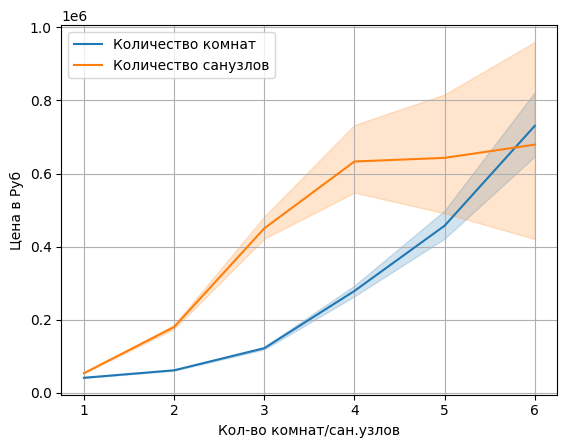

In [17]:
#Выводим графики зависимостей Кол-ва Комнат и Кол-ва Сан.узлов от цены
sns.lineplot(data=df2, y='price_RUR', x='rooms', label='Количество комнат')
sns.lineplot(data=df2, y='price_RUR', x='bathrooms', label='Количество санузлов')
plt.xlabel("Кол-во комнат/сан.узлов")
plt.ylabel("Цена в Руб")
plt.grid()

In [18]:
df2.head(10)

,ID,rooms,apt_type,metro,address,apartment_sqm,floors_and_type,parking,price,tel,...,kids_pets,utilities,building_name,building_series,ceiling_height,elevator,trash,cian link,price_RUR,bathrooms
0,271271157,4.0,Квартира,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,...,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,500000.0,NaN
1,271634126,4.0,Квартира,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,...,Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,500000.0,3.0
2,271173086,4.0,Квартира,м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384",...,Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,500000.0,3.0
3,272197456,4.0,Квартира,м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",...,Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,400000.0,3.0
4,273614615,2.0,Квартира,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,...,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,225000.0,2.0
5,274837728,3.0,Квартира,м. Смоленская (5 мин пешком),"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,...,NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Smolensky De Luxe,NaN,NaN,NaN,NaN,https://www.cian.ru/rent/flat/274837728,470000.0,NaN
6,273643908,5.0,Квартира,м. Арбатская (4 мин пешком),"Москва, переулок Романов, 3С1",213.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",...,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/273643908,350000.0,2.0
7,274475342,3.0,Квартира,м. Смоленская (3 мин пешком),"Москва, улица Арбат, 43С3",98.0,"2/4, Монолитный",подземная,"250000.0 руб./ За месяц, Залог - 250000 руб., ...",+79152004882,...,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),Нет,https://www.cian.ru/rent/flat/274475342,250000.0,2.0
8,273973191,3.0,Квартира,м. Смоленская (9 мин пешком),"Москва, Новинский бульвар, 18С1",120.0,"5/10, Сталинский",открытая,"130000.0 руб./ За месяц, Залог - 130000 руб., ...",+79153429055,...,Можно с животными,"Мебель на кухне, Ванна, Стиральная машина, Кон...",NaN,NaN,3.0,Пасс (1),Нет,https://www.cian.ru/rent/flat/273973191,130000.0,1.0
9,272900409,4.0,Квартира,м. Арбатская (10 мин пешком),"Москва, улица Арбат, 30/3С1",90.0,"2/7, Сталинский",открытая,"210000.0 руб./ За месяц, Залог - 210000 руб., ...",+79850610614,...,Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Сти...",NaN,NaN,310.0,Пасс (1),Да,https://www.cian.ru/rent/flat/272900409,210000.0,2.0
